In [1]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set()
%matplotlib inline

# machine learning
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Perceptron
from matplotlib.cbook import _string_to_bool
from mpl_toolkits.mplot3d import Axes3D

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# get titanic csv file as a DataFrame
titanic_df = pd.read_csv("titanic.csv", dtype={"Age": np.float64}, )

In [3]:
titanic_df.info()
titanic_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1310 entries, 0 to 1309
Data columns (total 14 columns):
pclass       1309 non-null float64
survived     1309 non-null float64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null float64
parch        1309 non-null float64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(7), object(7)
memory usage: 153.5+ KB


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,,female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
titanic_df = titanic_df.drop(['name','ticket','home.dest','body','boat'], axis=1)

In [5]:
#Boat

#titanic_df['boat'] = titanic_df['boat'].fillna(0)
#def fix_boat(passenger):
#    boat = passenger
#    if boat > 0:
#        return 1
#    else:
#        return 0
    
#titanic_df['boat'] = fix_boat(titanic_df['boat'])

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


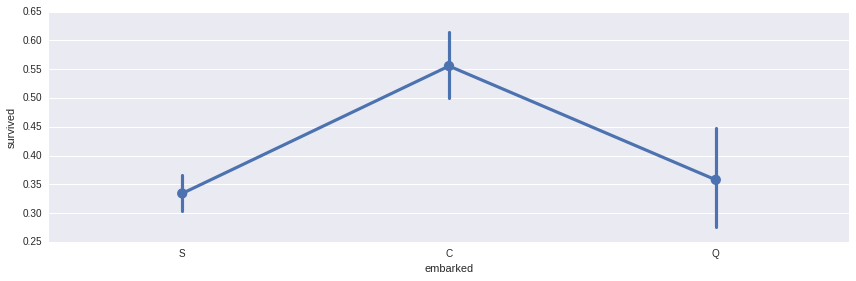

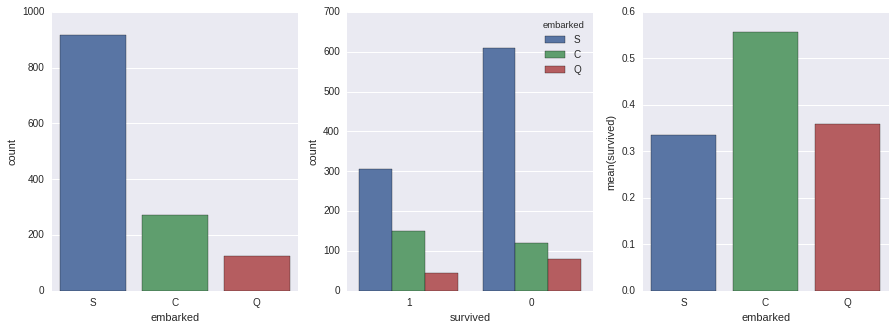

In [6]:
# Embarked

#fill the two missing values with the most occurred value, which is "S".
titanic_df["embarked"] = titanic_df["embarked"].fillna("S")

# plot
sbn.factorplot('embarked','survived', data=titanic_df,size=4,aspect=3)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

sbn.countplot(x='embarked', data=titanic_df, ax=axis1)
sbn.countplot(x='survived', hue="embarked", data=titanic_df, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = titanic_df[["embarked", "survived"]].groupby(['embarked'],as_index=False).mean()
sbn.barplot(x='embarked', y='survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

embark_dummies_titanic  = pd.get_dummies(titanic_df['embarked'])
#embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

titanic_df = titanic_df.join(embark_dummies_titanic)

titanic_df.drop(['embarked'], axis=1,inplace=True)

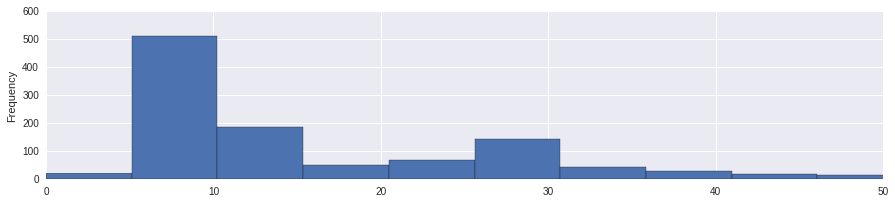

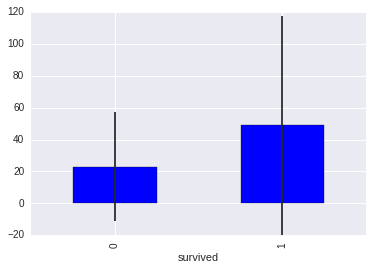

In [7]:
# Fare

# there are missing "Fare" values
titanic_df["fare"].fillna(titanic_df["fare"].median(), inplace=True)

# convert from float to int
titanic_df['fare'] = titanic_df['fare'].astype(int)

# get fare for survived & didn't survive passengers 
fare_not_survived = titanic_df["fare"][titanic_df["survived"] == 0]
fare_survived     = titanic_df["fare"][titanic_df["survived"] == 1]

# get average and std for fare of survived/not survived passengers
avgerage_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare      = DataFrame([fare_not_survived.std(), fare_survived.std()])

# plot
titanic_df['fare'].plot(kind='hist', figsize=(15,3),bins=100, xlim=(0,50))

avgerage_fare.index.names = std_fare.index.names = ["survived"]
avgerage_fare.plot(yerr=std_fare,kind='bar',legend=False)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


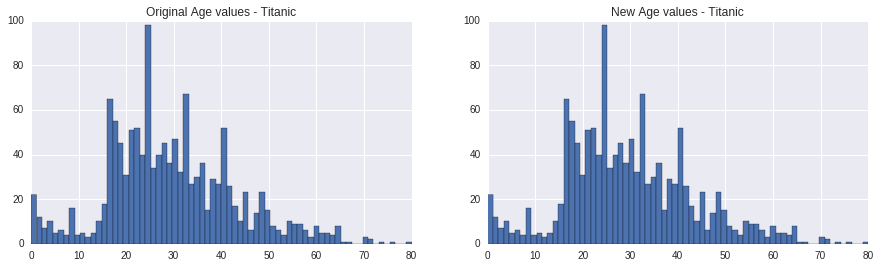

In [8]:
# Age 

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

# average, std, and number of NaN values
average_age_titanic   = titanic_df["age"].mean()
std_age_titanic       = titanic_df["age"].std()
count_nan_age_titanic = titanic_df["age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age_titanic - std_age_titanic, 
                           average_age_titanic + std_age_titanic, size = count_nan_age_titanic)

# fill NaN values with random values generated
titanic_df["age"][np.isnan(titanic_df["age"])] = rand_1

# convert from float to int
titanic_df['age'] = titanic_df['age'].astype(int)

# plot
titanic_df['age'].hist(bins=70, ax=axis1)
titanic_df['age'].hist(bins=70, ax=axis2)

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


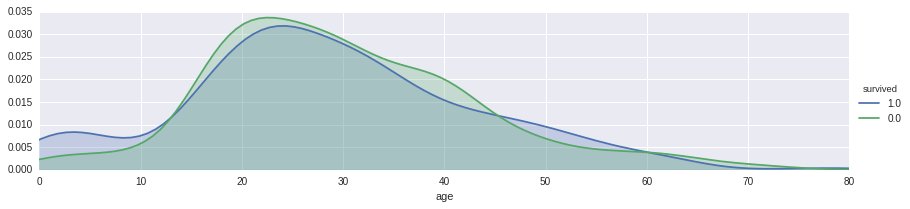

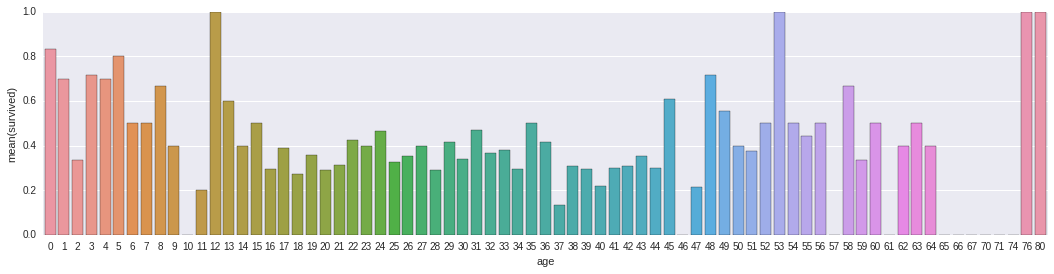

In [9]:
# .... continue with plot Age column

# peaks for survived/not survived passengers by their age
facet = sbn.FacetGrid(titanic_df, hue="survived",aspect=4)
facet.map(sbn.kdeplot,'age',shade= True)
facet.set(xlim=(0, titanic_df['age'].max()))
facet.add_legend()

# average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = titanic_df[["age", "survived"]].groupby(['age'],as_index=False).mean()
sbn.barplot(x='age', y='survived', data=average_age)

In [10]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
titanic_df.drop("cabin",axis=1,inplace=True)

In [11]:
# Family

# Instead of having two columns Parch & SibSp, 
# we can have only one column represent if the passenger had any family member aboard or not,
# Meaning, if having any family member(whether parent, brother, ...etc) will increase chances of Survival or not.
titanic_df['family'] = titanic_df["parch"] + titanic_df["sibsp"]

# drop Parch & SibSp
titanic_df = titanic_df.drop(['sibsp','parch'], axis=1)

# plot
#fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# sns.factorplot('Family',data=titanic_df,kind='count',ax=axis1)
#sbn.countplot(x='family', data=titanic_df, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
#family_perc = titanic_df[["family", "survived"]].groupby(['family'],as_index=False).mean()
#sbn.barplot(x='family', y='survived', data=family_perc, order=[1,0], ax=axis2)

#axis1.set_xticklabels(["With Family","Alone"], rotation=0)

In [12]:
#titanic_df.head()

In [13]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def is_child(passenger):
    age = passenger
    if age < 15:
        return 1
    else:
        return 0
    
def is_male(passenger):
    sex, child = passenger
    if child == 1:
        return 0
    if sex == 'male':
        return 1
    else:
        return 0
    
def is_female(passenger):
    sex, child = passenger
    if child == 1:
        return 0
    if sex == 'female':
        return 1
    else:
        return 0

def male_female(passenger):
    sex = passenger.data
    if sex == 'male':
        return 1
    else:
        return 0
        

titanic_df['child'] = titanic_df['age'].apply(is_child)
titanic_df['male'] = titanic_df[['sex','child']].apply(is_male,axis=1)
titanic_df['female'] = titanic_df[['sex','child']].apply(is_female,axis=1)
#titanic_df['sex'] = titanic_df[['sex']].apply(male_female,axis=1)

# No need to use Sex column since we created Person column
titanic_df.drop(['sex'],axis=1,inplace=True)

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


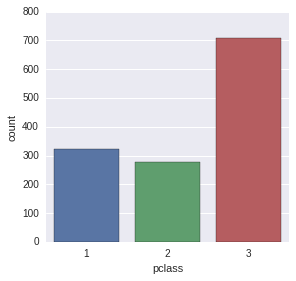

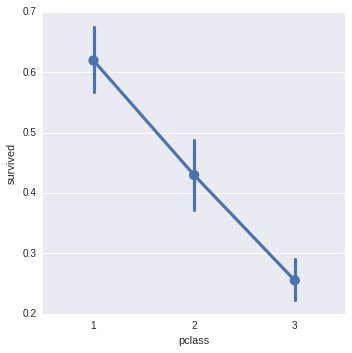

In [14]:
# Pclass

sbn.factorplot('pclass',data=titanic_df,kind='count',order=[1,2,3])
sbn.factorplot('pclass','survived',order=[1,2,3], data=titanic_df,size=5)

# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
pclass_dummies_titanic  = pd.get_dummies(titanic_df['pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
#pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

titanic_df.drop(['pclass'],axis=1,inplace=True)

titanic_df = titanic_df.join(pclass_dummies_titanic)

In [15]:
titanic_df = titanic_df.fillna(0)
from sklearn.decomposition import PCA
Xpca = PCA(3).fit_transform(titanic_df)
Xpca.shape
titanic_df.head()

,survived,age,fare,C,Q,S,family,child,male,female,Class_1,Class_2,Class_3
0,1,29,211,0,0,1,0,0,0,1,1,0,0
1,1,0,151,0,0,1,3,1,0,0,1,0,0
2,0,2,151,0,0,1,3,1,0,0,1,0,0
3,0,30,151,0,0,1,3,0,1,0,1,0,0
4,0,25,151,0,0,1,3,0,0,1,1,0,0


TypeError: scatter() missing 1 required positional argument: 'self'

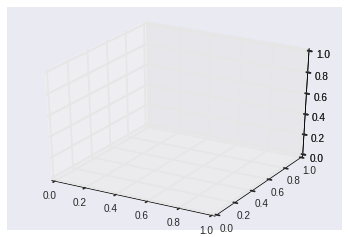

In [28]:
fig=plt.figure()
ax = fig.add_subplot(111, projection = '3d')
Axes3D.scatter(xs=Xpca[:, 0],ys=Xpca[:, 1],)
#plt.scatter(Xpca[:, 0], Xpca[:, 1], c = titanic_df.survived, cmap='Reds')


In [ ]:
titanic_df = titanic_df.fillna(0)
titanic_df = titanic_df.drop(['fare','Q','S','Class_2'], axis=1)
titanic_df.head()

In [ ]:
# define training and testing sets
survived_df = titanic_df["survived"]
x_train, x_test, y_train, y_test = train_test_split(titanic_df, survived_df,train_size=0.6)
X_train = x_train.drop("survived", axis=1)
Y_train = y_train
X_test  = x_test.drop("survived", axis=1)

X_test.head()

In [ ]:
percep = Perceptron(n_jobs=5)

parameters = {'n_iter':(5,10,100,1000,10000),
              'shuffle':(True,False)
              }

grid_percep = GridSearchCV(percep, parameters, n_jobs=-1,cv=50)
grid_percep.fit(X_train, Y_train)

Y_pred = grid_percep.predict(X_test)

target_names = ['died','survived']

best_parameters, score, _ = max(grid_percep.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

print(grid_percep.score(X_train, Y_train))
print(metrics.classification_report(y_test, Y_pred,target_names=target_names))

cm = metrics.confusion_matrix(y_test, Y_pred)
print(cm)

plt.imshow(np.log(confusion_matrix(y_test, Y_pred)),
           cmap = 'Blues', interpolation = 'nearest')
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

In [ ]:
# Logistic Regression

logreg = LogisticRegression(dual=True,C=.9,solver='newton-cg')

parameters = {}

grid_logreg = GridSearchCV(logreg, parameters, n_jobs=-1,cv=50)
grid_logreg.fit(X_train, Y_train)

Y_pred = grid_logreg.predict(X_test)

target_names = ['died','survived']

best_parameters, score, _ = max(grid_logreg.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

print(grid_logreg.score(X_train, Y_train))
print(metrics.classification_report(y_test, Y_pred,target_names=target_names))

cm = metrics.confusion_matrix(y_test, Y_pred)
print(cm)

plt.imshow(np.log(confusion_matrix(y_test, Y_pred)),
           cmap = 'Blues', interpolation = 'nearest')
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

In [ ]:
#print(grid_logreg.predict_proba([22,31,1,0,0,0,0,0,1,1,0,0]))
#print(grid_logreg.predict_proba([22,12,1,0,0,0,0,0,1,0,1,0]))

In [ ]:
# Support Vector Machines

svc = SVC(kernel='linear',probability=True,C=0.6)

parameters = {}

grid_svc = GridSearchCV(svc, parameters, n_jobs=-1,cv=50)
grid_svc.fit(X_train, Y_train)

grid_svc.fit(X_train, Y_train)

Y_pred = grid_svc.predict(X_test)

target_names = ['died','survived']
print(grid_svc.score(X_train, Y_train))
print(metrics.classification_report(y_test, Y_pred,target_names=target_names))

cm = metrics.confusion_matrix(y_test, Y_pred)
print(cm)

plt.imshow(np.log(confusion_matrix(y_test, Y_pred)),
           cmap = 'Blues', interpolation = 'nearest')
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

In [ ]:
best_parameters, score, _ = max(grid_svc.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
# Random Forests

random_forest = RandomForestClassifier(n_jobs=-1,n_estimators=10,max_depth=5,max_features='log2')

parameters = {}

grid_forest = GridSearchCV(random_forest, parameters, n_jobs=-1,cv=50)
grid_forest.fit(X_train, Y_train)

Y_pred = grid_forest.predict(X_test)

target_names = ['died','survived']

best_parameters, score, _ = max(grid_forest.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
    
print(grid_forest.score(X_train, Y_train))
print(metrics.classification_report(y_test, Y_pred,target_names=target_names))

cm = metrics.confusion_matrix(y_test, Y_pred)
print(cm)

plt.imshow(np.log(confusion_matrix(y_test, Y_pred)),
           cmap = 'Blues', interpolation = 'nearest')
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

In [ ]:
knn = KNeighborsClassifier(algorithm='brute',n_neighbors=9)

parameters = {}

grid_knn = GridSearchCV(knn, parameters, n_jobs=-1,cv=50)
grid_knn.fit(X_train, Y_train)

Y_pred = grid_knn.predict(X_test)

target_names = ['died','survived']

best_parameters, score, _ = max(grid_knn.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

print(grid_knn.score(X_train, Y_train))
print(metrics.classification_report(y_test, Y_pred,target_names=target_names))

cm = metrics.confusion_matrix(y_test, Y_pred)
print(cm)

plt.imshow(np.log(confusion_matrix(y_test, Y_pred)),
           cmap = 'Blues', interpolation = 'nearest')
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

In [ ]:
# Gaussian Naive Bayes

gaussian = GaussianNB()

gaussian.fit(X_train, Y_train)

Y_pred = gaussian.predict(X_test)

target_names = ['died','survived']

print(gaussian.score(X_train, Y_train))
print(metrics.classification_report(y_test, Y_pred,target_names=target_names))
#print(np.log(confusion_matrix(y_test, Y_pred)))

cm = metrics.confusion_matrix(y_test, Y_pred)
print(cm)

plt.imshow(np.log(confusion_matrix(y_test, Y_pred)),
           cmap = 'Blues', interpolation = 'nearest')
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

In [ ]:
# get Correlation Coefficient for each feature using Logistic Regression
logreg.fit(X_train, Y_train)

coeff_df = DataFrame(titanic_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
coeff_df